

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
import sys
display(sys.version)
sys.path
!echo $PATH

'3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]'

/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/users/ak/yd/cfg/scripts:/Users/ak/.cargo/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/users/ak/yd/cfg/scripts:/Users/ak/opt/anaconda3/condabin:/Users/ak/.cargo/bin


In [4]:
# !pip install -U torch torchvision

In [5]:
# # установка подходящей версии torch

# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# print(platform)
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

In [6]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [7]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0

In [8]:
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

5.3.0


In [9]:
!nvidia-smi
import torch
torch.cuda.is_available()

zsh:1: command not found: nvidia-smi


False

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [44]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [45]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [46]:
wd = '/content/drive/MyDrive/dls1/05simpsons/'
wd = './'
TRAIN_DIR = Path(wd + 'trainset')
TEST_DIR = Path(wd + 'testset')
print(type(TRAIN_DIR))
print(TRAIN_DIR)

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

<class 'pathlib.PosixPath'>
trainset


In [47]:
x = np.array(Image.open(next(iter(train_val_files))).resize((RESCALE_SIZE, RESCALE_SIZE)))
y = np.array(x / 255, np.float32)
# print(x)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
x = transform(x)
y = transform(y)
type(x)
print(x.size())
print(x.shape)
print(np.prod(x.shape))
print(3 * 224 * 224)
out = nn.Linear(np.prod(x.shape), 5)
x = x.view((x.size(0), -1))
print(x.dim())
print(x.shape)
# x = Variable(x)
out.forward(x)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
150528
150528
2
torch.Size([3, 50176])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x50176 and 150528x5)

In [48]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
print(len(val_files))
print(len(train_files))
print(type(next(iter(val_files))))

5232
15694
<class 'pathlib.PosixPath'>


In [49]:
val_dataset = SimpsonsDataset(val_files, mode='val')
len(val_dataset)

5232

In [50]:
np.random.seed(42)
idx = np.random.randint(0, 1000)
print(idx)
sample, sample_y = val_dataset[idx]
print(sample.min(), sample.max())
print(sample)

102
tensor(-2.1179) tensor(2.6400)
tensor([[[ 0.1939,  0.1939,  0.1939,  ..., -0.2856, -0.2856, -0.2856],
         [ 0.1939,  0.1939,  0.1939,  ..., -0.2856, -0.2856, -0.2856],
         [ 0.1939,  0.1939,  0.1939,  ..., -0.2856, -0.2856, -0.2856],
         ...,
         [ 0.1939,  0.1939,  0.1939,  ...,  0.2796,  0.2796,  0.2796],
         [ 0.1939,  0.1939,  0.1939,  ...,  0.2967,  0.2796,  0.2796],
         [ 0.1939,  0.1939,  0.1939,  ...,  0.2967,  0.2796,  0.2796]],

        [[ 0.5378,  0.5378,  0.5378,  ..., -0.5126, -0.5126, -0.5126],
         [ 0.5378,  0.5378,  0.5378,  ..., -0.5126, -0.5126, -0.5126],
         [ 0.5378,  0.5378,  0.5378,  ..., -0.5126, -0.5126, -0.5126],
         ...,
         [ 0.5553,  0.5553,  0.5553,  ...,  0.4853,  0.4678,  0.4503],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.5028,  0.4678,  0.4503],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.5028,  0.4678,  0.4503]],

        [[-0.0441, -0.0441, -0.0441,  ...,  0.6008,  0.6008,  0.6008],
         [

In [51]:
# # uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

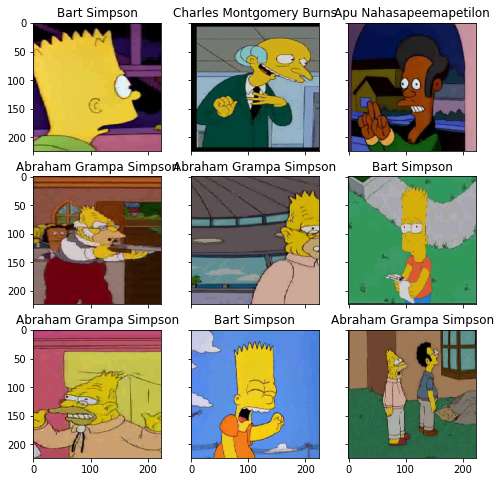

In [52]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    # random_characters = int(np.random.uniform(0,1000))
    random_characters = np.random.randint(0,1000)
    # np.random.int()
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [53]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [64]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

        # with tqdm(desc="n_processed_samples", total=len(val_dataset)) as pbar:
    for inputs, labels in tqdm(train_loader):
      inputs = inputs.to(DEVICE) 
      labels = labels.to(DEVICE)

      n_samples = inputs.size(0)

      #clear grad
      optimizer.zero_grad()

      #forward
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      #backward
      loss.backward()

      #step
      optimizer.step()

      # loss
      running_loss += loss.item() * n_samples

      # accuracy
      preds = torch.argmax(outputs, 1)
      running_corrects += torch.sum(preds == labels.data) # accuracy

      # for mean loss and accuracy total number of samples in the epoch needed
      processed_data += n_samples
      # pbar.update(inputs.shape[0])
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [65]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [66]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [67]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [68]:
DEVICE = torch.device("cpu")
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [69]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [70]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

100%|██████████| 246/246 [09:24<00:00,  2.29s/it]


loss 2.453703044432203


  0%|          | 0/246 [00:00<?, ?it/s]


Epoch 001 train_loss: 2.4537     val_loss 1.8344 train_acc 0.3224 val_acc 0.5128



100%|██████████| 246/246 [07:11<00:00,  1.75s/it]


loss 1.4870571125475818


epoch: 100%|██████████| 2/2 [19:39<00:00, 589.74s/it]


Epoch 002 train_loss: 1.4871     val_loss 1.2628 train_acc 0.5971 val_acc 0.6577


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

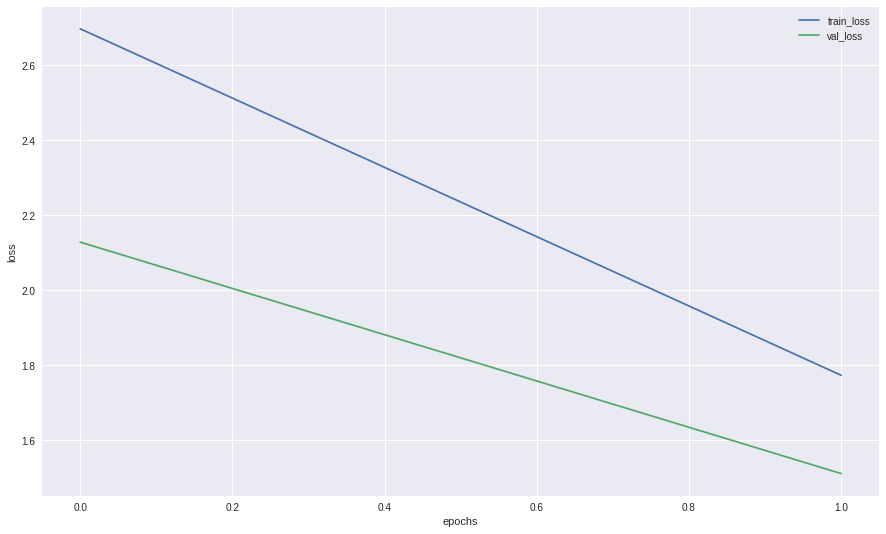

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
idxs = np.random.randint(0, 1000, 2)
subset = torch.utils.data.Subset(val_dataset, idxs)
loader = torch.utils.data.DataLoader(subset, batch_size=len(subset))
samples = next(iter(loader))[0]
display(samples[0])
probs = predict_one_sample(simple_cnn, samples, device=torch.device("cpu"))
len(probs)
probs.shape

tensor([[[-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
         [-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
         [-0.0629, -0.0629, -0.0629,  ..., -0.0629, -0.0629, -0.0629],
         ...,
         [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042],
         [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042],
         [-1.6042, -1.6042, -1.6042,  ..., -1.6042, -1.6042, -1.6042]],

        [[-0.6877, -0.6877, -0.6877,  ..., -0.6877, -0.6877, -0.6877],
         [-0.6877, -0.6877, -0.6877,  ..., -0.6877, -0.6877, -0.6877],
         [-0.6877, -0.6877, -0.6877,  ..., -0.6877, -0.6877, -0.6877],
         ...,
         [ 0.0476,  0.0476,  0.0476,  ...,  0.0476,  0.0476,  0.0476],
         [ 0.0476,  0.0476,  0.0476,  ...,  0.0476,  0.0476,  0.0476],
         [ 0.0476,  0.0476,  0.0476,  ...,  0.0476,  0.0476,  0.0476]],

        [[-1.2467, -1.2467, -1.2467,  ..., -1.2467, -1.2467, -1.2467],
         [-1.2467, -1.2467, -1.2467,  ..., -1

array([[0.02461144, 0.02353337, 0.02395697, 0.02381514, 0.02280287,
        0.02342496, 0.02415046, 0.02345312, 0.02393203, 0.02352677,
        0.0237775 , 0.02279454, 0.02421544, 0.02464828, 0.02370622,
        0.02404978, 0.02468567, 0.02264827, 0.02335753, 0.02501488,
        0.0239228 , 0.02404081, 0.02360536, 0.02371863, 0.02370352,
        0.02479624, 0.02353371, 0.02355617, 0.02249242, 0.02397485,
        0.02401424, 0.02293254, 0.02511966, 0.02491885, 0.02311892,
        0.02463398, 0.02251123, 0.02323556, 0.0238058 , 0.02407968,
        0.02485427, 0.0233254 ],
       [0.02449006, 0.02342555, 0.02415897, 0.02370605, 0.02316209,
        0.02344709, 0.02444578, 0.02319632, 0.02397861, 0.02346779,
        0.02380328, 0.02294997, 0.0243605 , 0.02449595, 0.02333743,
        0.02377987, 0.02455667, 0.02252983, 0.02340747, 0.02506138,
        0.02425057, 0.02445642, 0.02355757, 0.02370499, 0.02391801,
        0.02506842, 0.02319174, 0.02356607, 0.02248802, 0.0238818 ,
        0.02379

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
type([(i**2 for i in range(5))])

list

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class)


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


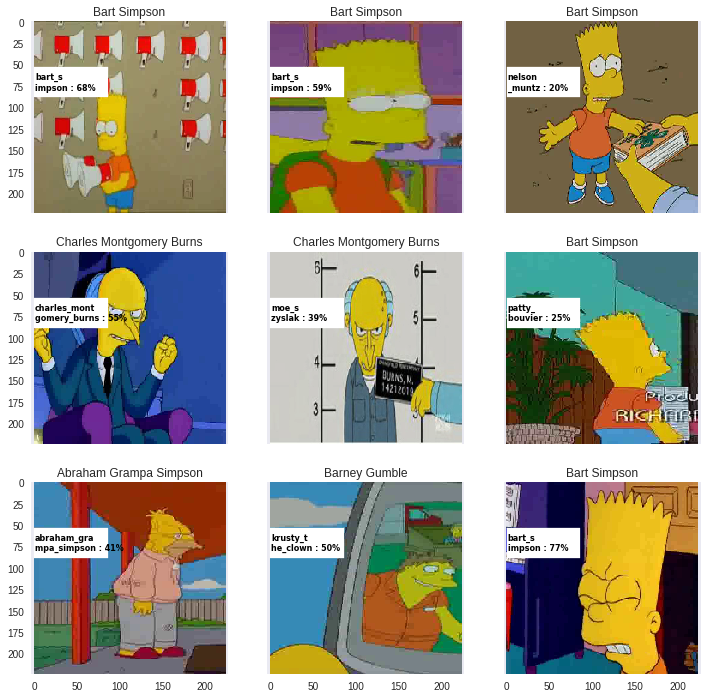

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)
print(next(iter(test_loader))[0])
pass
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


tensor([[[[-0.7993, -0.7993, -0.7993,  ..., -0.1486, -0.1657, -0.1143],
          [-0.4397, -0.4397, -0.4397,  ...,  0.2624,  0.2967,  0.2796],
          [-0.2856, -0.2856, -0.2856,  ...,  0.2967,  0.2453,  0.3138],
          ...,
          [-0.8678, -0.8678, -0.8678,  ...,  0.3823,  0.3823,  0.3823],
          [-0.8678, -0.8678, -0.8678,  ...,  0.7419,  0.7419,  0.7419],
          [-0.8678, -0.8678, -0.8678,  ...,  0.5193,  0.5193,  0.5193]],

         [[-1.1429, -1.1429, -1.1429,  ..., -1.1253, -1.1429, -1.1078],
          [-0.7752, -0.7752, -0.7752,  ..., -0.7052, -0.6702, -0.6877],
          [-0.6176, -0.6176, -0.6176,  ..., -0.6352, -0.6877, -0.6527],
          ...,
          [-0.6352, -0.6352, -0.6352,  ...,  0.6779,  0.6779,  0.6779],
          [-0.6352, -0.6352, -0.6352,  ...,  0.9055,  0.9055,  0.9055],
          [-0.6352, -0.6352, -0.6352,  ...,  0.5903,  0.5903,  0.5903]],

         [[-0.0964, -0.0964, -0.0964,  ..., -0.6018, -0.6193, -0.5844],
          [ 0.2696,  0.2696,  

AttributeError: 'list' object has no attribute 'to'

In [ ]:
! ls 

In [ ]:
import pandas as pd
my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
